In [14]:
# !pip install filterpy

     ---------------------------------------- 0.0/178.0 kB ? eta -:--:--
     -- ------------------------------------- 10.2/178.0 kB ? eta -:--:--
     -------- ---------------------------- 41.0/178.0 kB 393.8 kB/s eta 0:00:01
     ------------------------ ----------- 122.9/178.0 kB 901.1 kB/s eta 0:00:01
     -------------------------------------- 178.0/178.0 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110542 sha256=1f311561175c7631fc0e8971537d049beb23165ea274da5ad424b44ca281c604
  Stored in directory: c:\users\dbezu\appdata\local\pip\cache\wheels\77\bf\4c\b0c3f4798a0166668752312a67118b27a3cd341e13ac0ae6ee
Successfully built filterpy


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from string import Template
import plots

from utils import *
from filters import * 
from auxilary import * 

In [2]:
data = pd.read_excel("data.xlsx")
data.head()

,begin,SBERBANK_open,SBERBANK_close,SBERBANK_high,SBERBANK_low,SBERBANK_value,SBERBANK_volume,SBERBANK_end,GAZPROM_open,GAZPROM_close,...,GAZPROM_value,GAZPROM_volume,GAZPROM_end,SEVERSTAL_open,SEVERSTAL_close,SEVERSTAL_high,SEVERSTAL_low,SEVERSTAL_value,SEVERSTAL_volume,SEVERSTAL_end
0,2023-01-03 09:59:00,141.98,141.98,141.98,141.98,623292.2,4390.0,2023-01-03 09:59:59,163.00,163.00,...,3202950.0,19650.0,2023-01-03 09:59:59,901.4,901.4,901.4,901.4,544445.6,604.0,2023-01-03 09:59:59
1,2023-01-03 10:00:00,141.39,141.77,141.98,141.35,5222705.0,36870.0,2023-01-03 10:00:59,163.02,162.97,...,9785043.9,60010.0,2023-01-03 10:00:59,902.4,900.0,903.0,899.4,2977627.8,3304.0,2023-01-03 10:00:59
2,2023-01-03 10:01:00,141.75,141.66,141.99,141.47,2848250.1,20070.0,2023-01-03 10:01:59,162.91,162.51,...,4853519.7,29840.0,2023-01-03 10:01:59,900.0,900.2,900.6,899.4,1663076.8,1848.0,2023-01-03 10:01:59
3,2023-01-03 10:02:00,141.58,141.64,141.66,141.58,1172537.4,8280.0,2023-01-03 10:02:59,162.51,162.66,...,6973666.8,42910.0,2023-01-03 10:02:59,900.0,899.6,900.0,899.2,336374.6,374.0,2023-01-03 10:02:59
4,2023-01-03 10:03:00,141.64,141.70,141.74,141.64,508607.6,3590.0,2023-01-03 10:03:59,162.66,162.44,...,5747959.5,35360.0,2023-01-03 10:03:59,899.6,900.0,900.2,899.6,1099767.4,1222.0,2023-01-03 10:03:59


In [3]:
companies = "SBERBANK", "GAZPROM", "SEVERSTAL"

cols = "open", "close", "high", "low", "volume"

col_template = Template("$company$col")

df = {}

for company in companies: 
    cols2fetch = [col_template.substitute(company=company+"_", col=col) for col in cols]
    df[company] = data[["begin"]+cols2fetch]

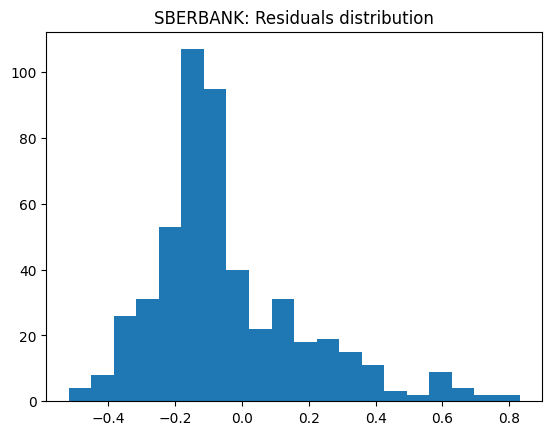

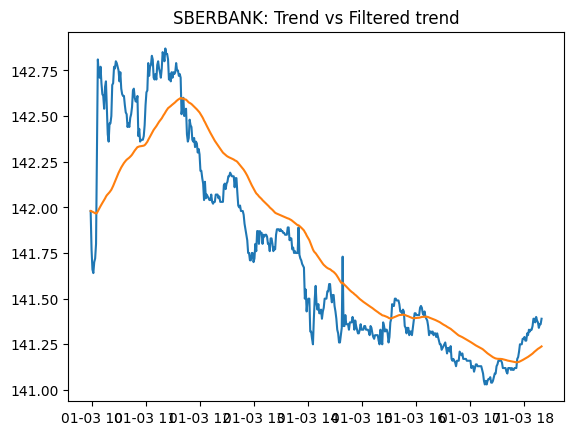

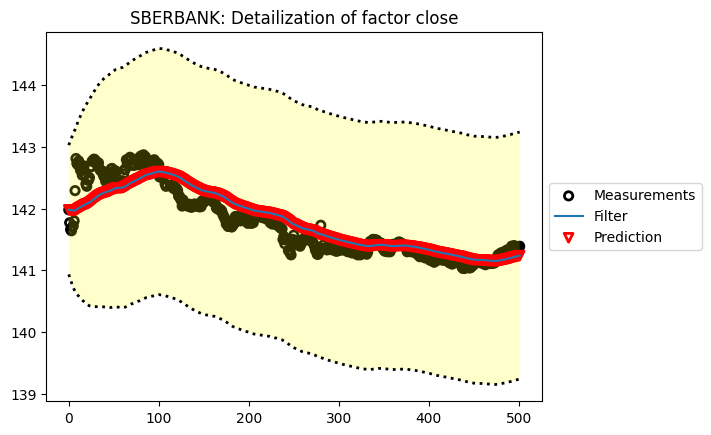

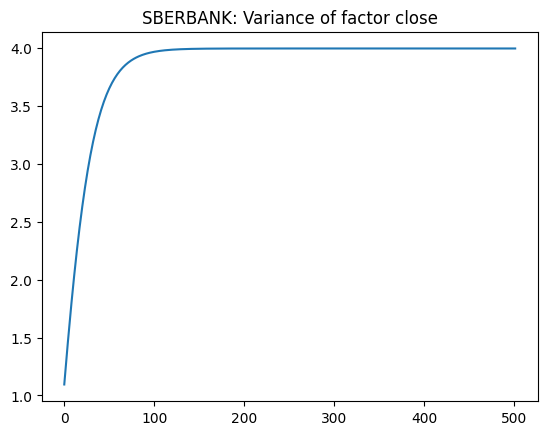

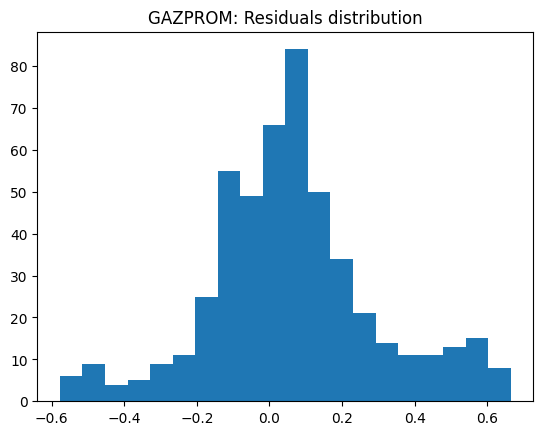

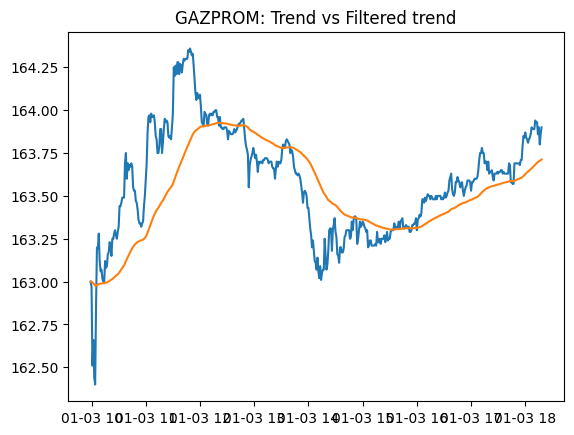

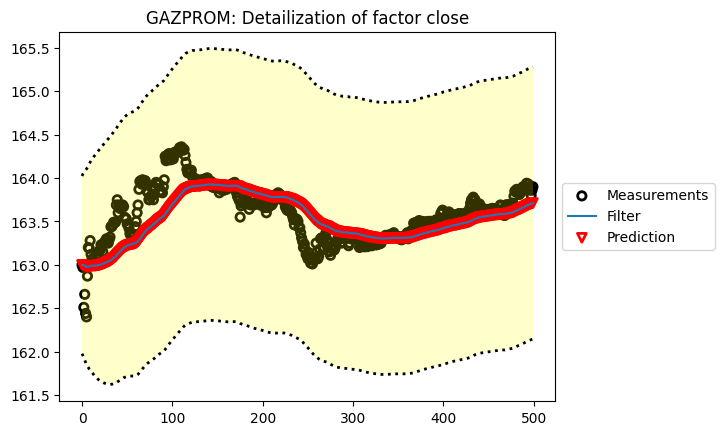

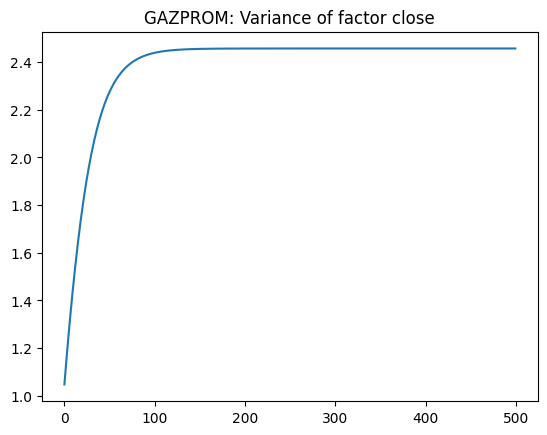

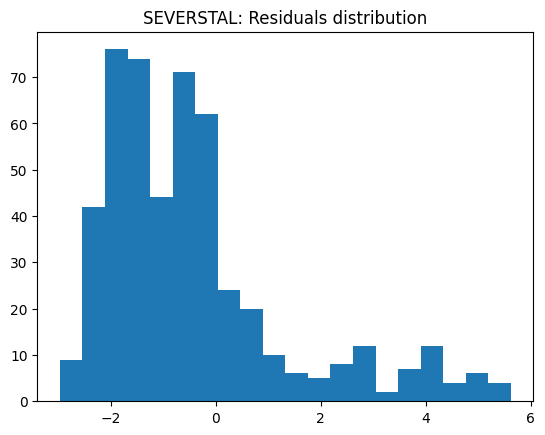

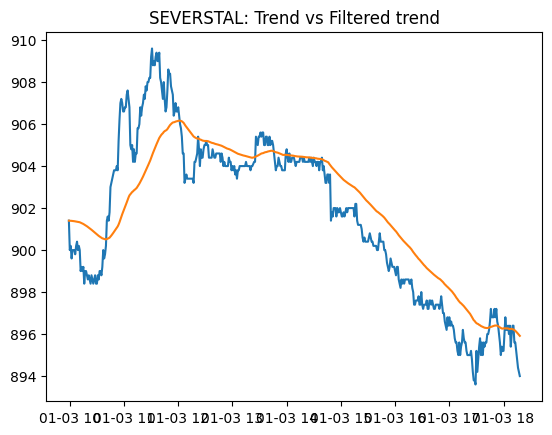

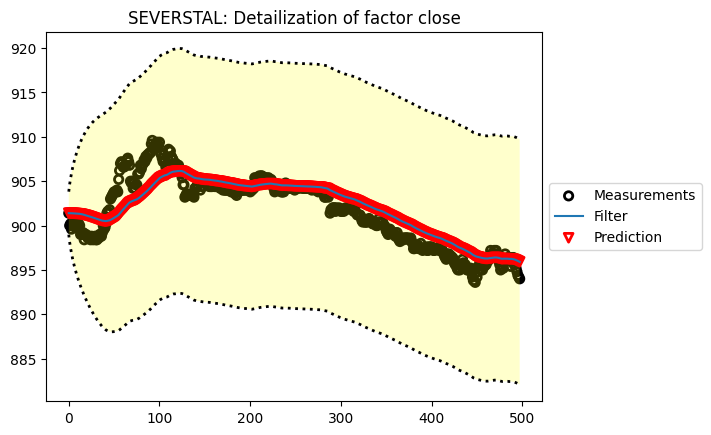

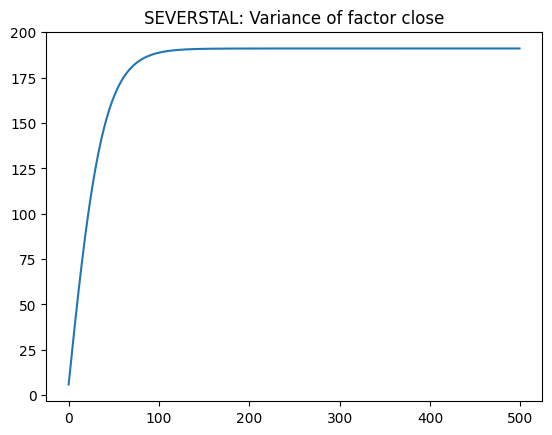

In [4]:
# Однофакторная модель на основе оценки MLE
COMPANY = "SBERBANK"
for COMPANY in companies:
    COL_GROUP = "begin"
    COL_DATA = "close"
    COL_DATA_FULL = f"{COMPANY}_{COL_DATA}"

    df_proc = df[COMPANY][[COL_GROUP, COL_DATA_FULL]].dropna()

    daily_groups = df_proc.groupby(pd.Grouper(key=COL_GROUP, freq="D"))

    filtered_data = []
    filtered_data_vars = []

    # Для каждой упорядоченной группы ...
    for _, group in daily_groups:
        if not group.empty:
            # инициализирующая генерация матриц
            matrices = generate_kalman_matrices_from_timeseries_old(group.filter(like=COL_DATA))
            Z = group[COL_DATA_FULL].to_numpy()

            filter_hist_states = np.empty(shape=Z.shape[0])
            filter_vars_states = np.empty(shape=Z.shape[0])

            optimized_params = optimize_kalman_parameters(
                Z=Z,
                Q_init=matrices['Q'],
                R_init=matrices['R'],
                x_init=matrices['x0'],
                P_init=matrices['P'],
                method='MLE'
            )

            kf = BaseKalmanFilter(
                F=matrices['F'],
                H=matrices['H'],
                Q=optimized_params['Q_opt'],
                R=optimized_params['R_opt'],
                P=matrices['P'],
                x0=matrices['x0']
            )

            for t in range(Z.shape[0]):
                observation = Z[t]

                kf.predict()
                kf.update(observation)

                filter_hist_states[t] = kf.get_state()[0]
                filter_vars_states[t] = kf.P[0,0]

            filtered_data.append(filter_hist_states)
            filtered_data_vars.append(filter_vars_states)

        break

    filtered_data = np.hstack(filtered_data)        
    filtered_data_vars = np.hstack(filtered_data_vars)

    processed_df = pd.concat([df_proc.begin, 
                            df_proc[COL_DATA_FULL],
                            pd.DataFrame(filtered_data, columns=["pred"]),
                            pd.DataFrame(filtered_data_vars, columns=["var_pred"])], axis=1).dropna()
    
    plt.hist(processed_df[COL_DATA_FULL] - processed_df["pred"], bins=20)
    plt.title(f'{COMPANY}: Residuals distribution')

    plt.show()

    plt.plot(processed_df.begin, processed_df[COL_DATA_FULL])
    plt.plot(processed_df.begin, processed_df["pred"])
    plt.title(f'{COMPANY}: Trend vs Filtered trend')

    plt.show()

    plots.plot_measurements(processed_df[COL_DATA_FULL])
    plots.plot_filter(processed_df["pred"], var=processed_df["var_pred"])
    plots.plot_predictions(processed_df["pred"])
    plots.show_legend()
    plt.title(f"{COMPANY}: Detailization of factor {COL_DATA}")

    plt.show()

    plt.plot(filtered_data_vars)
    plt.title(f'{COMPANY}: Variance of factor {COL_DATA}')

    plt.show()

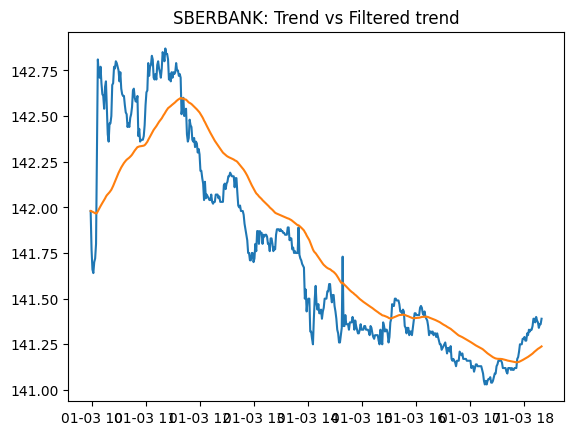

C:\Users\dbezu\AppData\Local\Temp\ipykernel_113592\2332311547.py:57: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  group[COL_DATA_FULL][t] = kf.get_state()[0]
C:\Users\dbezu\AppData\Local\Temp\ipykernel_113592\2332311547.py:57: SettingWithCo

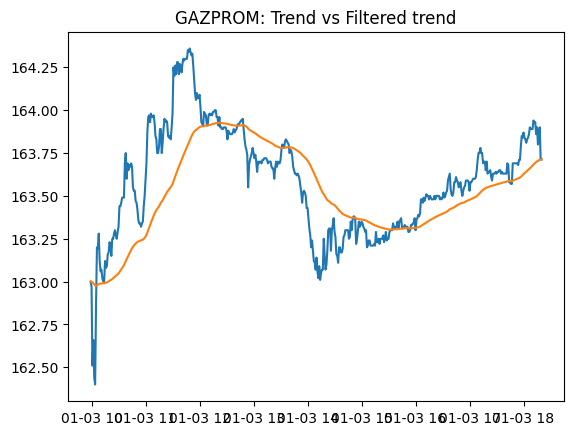

C:\Users\dbezu\AppData\Local\Temp\ipykernel_113592\2332311547.py:57: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  group[COL_DATA_FULL][t] = kf.get_state()[0]
C:\Users\dbezu\AppData\Local\Temp\ipykernel_113592\2332311547.py:57: SettingWithCo

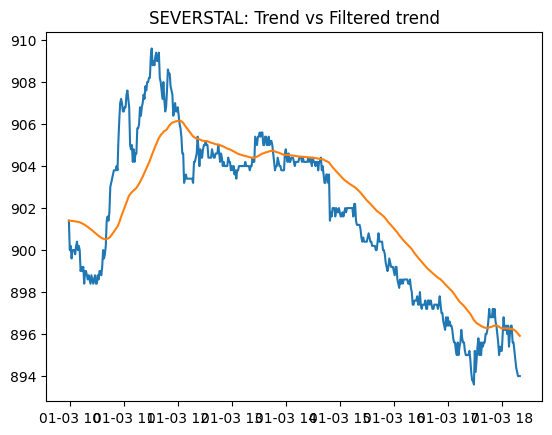

In [5]:
# заполнение пропусков

# Однофакторная модель на основе оценки MLE
COMPANY = "SBERBANK"
for COMPANY in companies:
    COL_GROUP = "begin"
    COL_DATA = "close"
    COL_DATA_FULL = f"{COMPANY}_{COL_DATA}"

    df_proc = df[COMPANY][[COL_GROUP, COL_DATA_FULL]]

    daily_groups = df_proc.groupby(pd.Grouper(key=COL_GROUP, freq="D"))

    filtered_data = []
    filtered_data_vars = []

    # Для каждой упорядоченной группы ...
    for _, group in daily_groups:
        if not group.empty:
            # инициализирующая генерация матриц
            matrices = generate_kalman_matrices_from_timeseries_old(group.filter(like=COL_DATA).dropna())
            Z = group[COL_DATA_FULL].dropna().to_numpy()

            filter_hist_states = np.empty(shape=group.shape[0])

            optimized_params = optimize_kalman_parameters(
                Z=Z,
                Q_init=matrices['Q'],
                R_init=matrices['R'],
                x_init=matrices['x0'],
                P_init=matrices['P'],
                method='MLE'
            )

            kf = BaseKalmanFilter(
                F=matrices['F'],
                H=matrices['H'],
                Q=optimized_params['Q_opt'],
                R=optimized_params['R_opt'],
                P=matrices['P'],
                x0=matrices['x0']
            )

            for t in range(group[COL_DATA_FULL].shape[0]):
                observation = group[COL_DATA_FULL][t]
                if observation == observation:

                    kf.predict()
                    kf.update(observation)

                    filter_hist_states[t] = kf.get_state()[0]

                else: 
                    kf.predict()
                    
                    filter_hist_states[t] = kf.get_state()[0]
                    group[COL_DATA_FULL][t] = kf.get_state()[0]

            filtered_data.append(filter_hist_states)

        break

    filtered_data = np.hstack(filtered_data)        

    processed_df = pd.concat([group.begin, 
                            group[COL_DATA_FULL],
                            pd.DataFrame(filtered_data, columns=["pred"])], axis=1).dropna()

    plt.plot(processed_df.begin, processed_df[COL_DATA_FULL])
    plt.plot(processed_df.begin, processed_df["pred"])
    plt.title(f'{COMPANY}: Trend vs Filtered trend')

    plt.show()

C:\Users\dbezu\AppData\Local\Temp\ipykernel_113592\3630343914.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  group[COL_DATA_FULL][nan_replacement] = np.nan
C:\Users\dbezu\AppData\Local\Temp\ipykernel_113592\3630343914.py:22: SettingWit

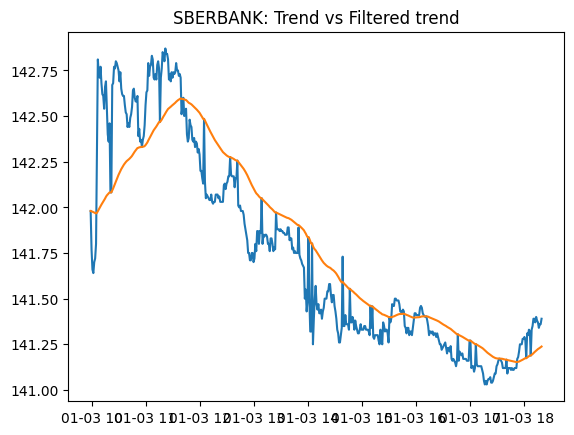

C:\Users\dbezu\AppData\Local\Temp\ipykernel_113592\3630343914.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  group[COL_DATA_FULL][nan_replacement] = np.nan
C:\Users\dbezu\AppData\Local\Temp\ipykernel_113592\3630343914.py:22: SettingWit

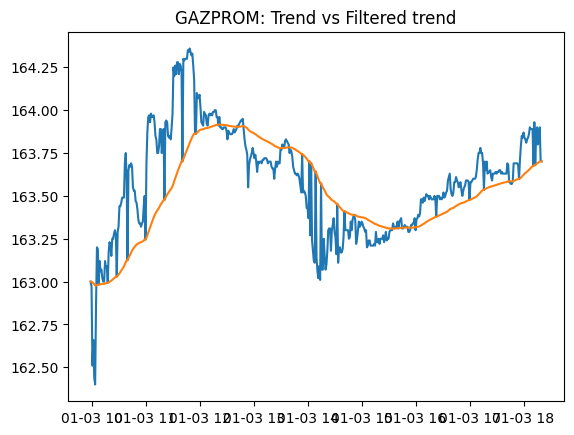

C:\Users\dbezu\AppData\Local\Temp\ipykernel_113592\3630343914.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  group[COL_DATA_FULL][nan_replacement] = np.nan
C:\Users\dbezu\AppData\Local\Temp\ipykernel_113592\3630343914.py:22: SettingWit

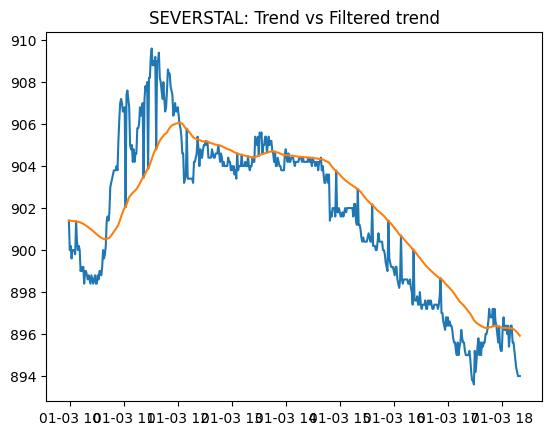

In [6]:
# больше NAN опций

# Однофакторная модель на основе оценки MLE
COMPANY = "SBERBANK"
for COMPANY in companies:
    COL_GROUP = "begin"
    COL_DATA = "close"
    COL_DATA_FULL = f"{COMPANY}_{COL_DATA}"

    df_proc = df[COMPANY][[COL_GROUP, COL_DATA_FULL]]

    daily_groups = df_proc.groupby(pd.Grouper(key=COL_GROUP, freq="D"))

    filtered_data = []
    filtered_data_vars = []

    # Для каждой упорядоченной группы ...
    for _, group in daily_groups:
        if not group.empty:
            # инициализирующая генерация матриц
            nan_replacement = group[COL_DATA_FULL].sample(frac=.05).index
            group[COL_DATA_FULL][nan_replacement] = np.nan

            matrices = generate_kalman_matrices_from_timeseries_old(group.filter(like=COL_DATA).dropna())
            Z = group[COL_DATA_FULL].dropna().to_numpy()

            filter_hist_states = np.empty(shape=group.shape[0])

            optimized_params = optimize_kalman_parameters(
                Z=Z,
                Q_init=matrices['Q'],
                R_init=matrices['R'],
                x_init=matrices['x0'],
                P_init=matrices['P'],
                method='MLE'
            )

            kf = BaseKalmanFilter(
                F=matrices['F'],
                H=matrices['H'],
                Q=optimized_params['Q_opt'],
                R=optimized_params['R_opt'],
                P=matrices['P'],
                x0=matrices['x0']
            )

            for t in range(group[COL_DATA_FULL].shape[0]):
                observation = group[COL_DATA_FULL][t]
                if observation == observation:

                    kf.predict()
                    kf.update(observation)

                    filter_hist_states[t] = kf.get_state()[0]

                else: 
                    kf.predict()
                    
                    filter_hist_states[t] = kf.get_state()[0]
                    group[COL_DATA_FULL][t] = kf.get_state()[0]

            filtered_data.append(filter_hist_states)

        break

    filtered_data = np.hstack(filtered_data)        

    processed_df = pd.concat([group.begin, 
                            group[COL_DATA_FULL],
                            pd.DataFrame(filtered_data, columns=["pred"])], axis=1).dropna()

    plt.plot(processed_df.begin, processed_df[COL_DATA_FULL])
    plt.plot(processed_df.begin, processed_df["pred"])
    plt.title(f'{COMPANY}: Trend vs Filtered trend')

    plt.show()

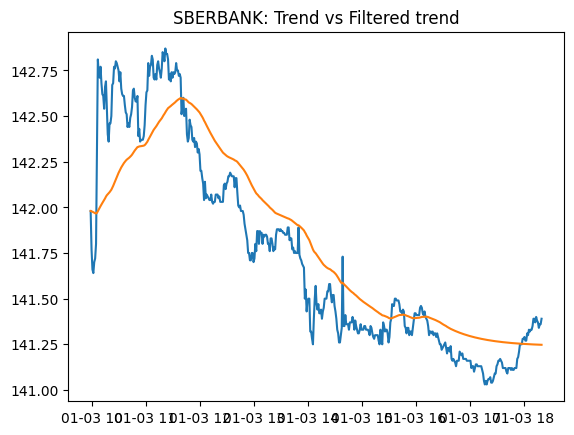

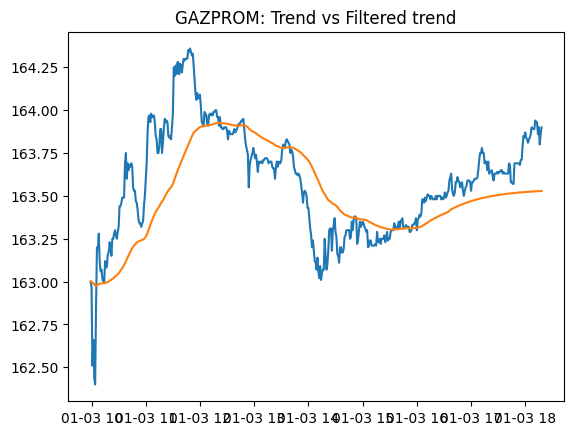

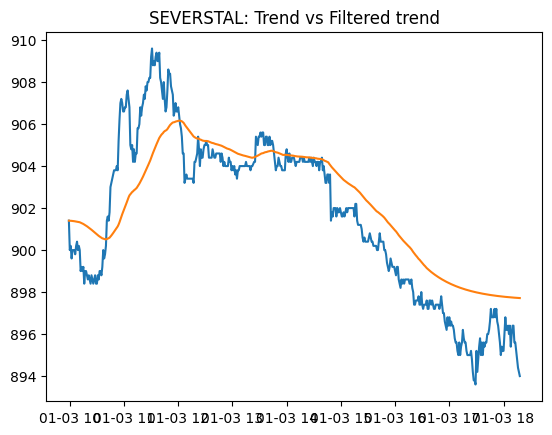

In [7]:
# больше NAN опций

# Однофакторная модель на основе оценки MLE
COMPANY = "SEVERSTAL"
for COMPANY in companies:
    
    COL_GROUP = "begin"
    COL_DATA = "close"
    COL_DATA_FULL = f"{COMPANY}_{COL_DATA}"

    df_proc = df[COMPANY][[COL_GROUP, COL_DATA_FULL]]

    daily_groups = df_proc.groupby(pd.Grouper(key=COL_GROUP, freq="D"))

    filtered_data = []
    filtered_data_vars = []

    # Для каждой упорядоченной группы ...
    for _, group in daily_groups:
        if not group.empty:
            # инициализирующая генерация матриц
            matrices = generate_kalman_matrices_from_timeseries_old(group.filter(like=COL_DATA).dropna())
            Z = group[COL_DATA_FULL].dropna().to_numpy()

            filter_hist_states = np.empty(shape=Z.shape[0])

            optimized_params = optimize_kalman_parameters(
                Z=Z,
                Q_init=matrices['Q'],
                R_init=matrices['R'],
                x_init=matrices['x0'],
                P_init=matrices['P'],
                method='MLE'
            )

            kf = BaseKalmanFilter(
                F=matrices['F'],
                H=matrices['H'],
                Q=optimized_params['Q_opt'],
                R=optimized_params['R_opt'],
                P=matrices['P'],
                x0=matrices['x0']
            )

            for t in range(Z.shape[0]):
                if t <= 400:
                    observation = Z[t]

                    kf.predict()
                    kf.update(observation)

                else:
                    kf.predict()
                    kf.update(observation)

                filter_hist_states[t] = kf.get_state()[0]

            filtered_data.append(filter_hist_states)

        break

    filtered_data = np.hstack(filtered_data)        

    processed_df = pd.concat([group.begin, 
                            group[COL_DATA_FULL],
                            pd.DataFrame(filtered_data, columns=["pred"])], axis=1).dropna()

    plt.plot(processed_df.begin, processed_df[COL_DATA_FULL])
    plt.plot(processed_df.begin, processed_df["pred"])
    plt.title(f'{COMPANY}: Trend vs Filtered trend')

    plt.show()

C:\Users\dbezu\AppData\Local\Temp\ipykernel_113592\3932278454.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  filter_vars_states[t] = ekf.P


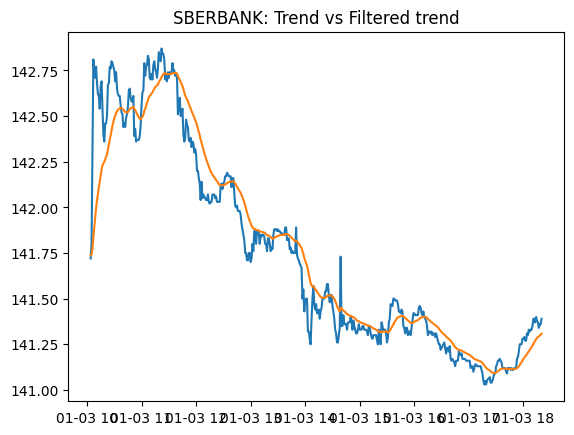

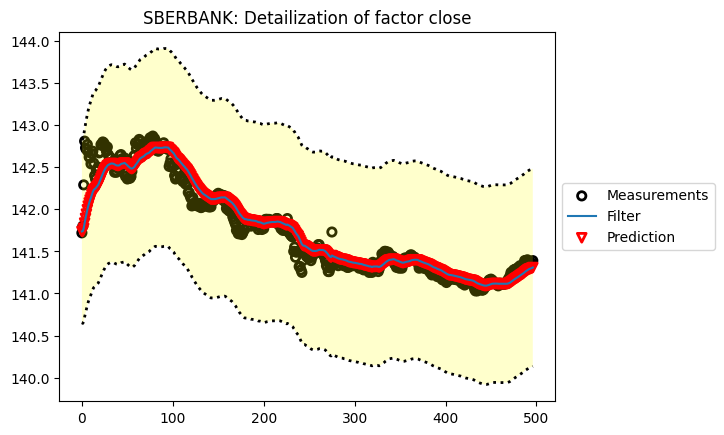

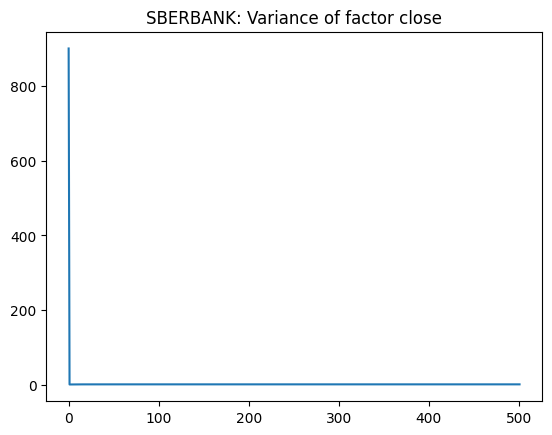

C:\Users\dbezu\AppData\Local\Temp\ipykernel_113592\3932278454.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  filter_vars_states[t] = ekf.P


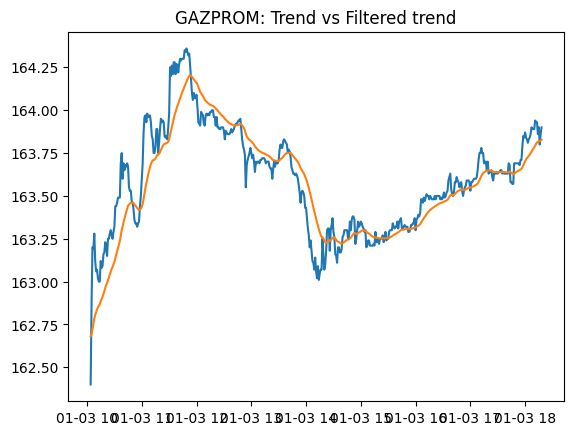

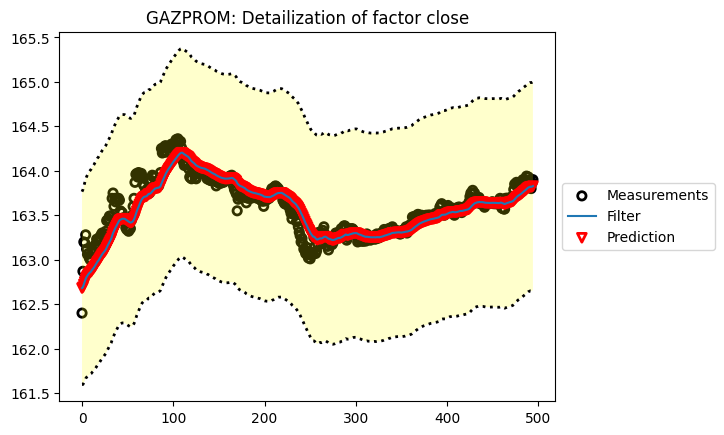

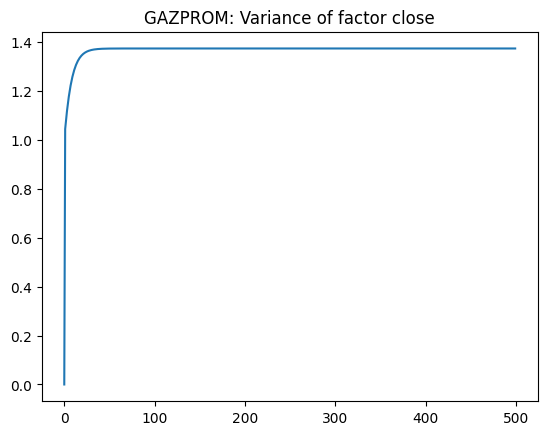

C:\Users\dbezu\AppData\Local\Temp\ipykernel_113592\3932278454.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  filter_vars_states[t] = ekf.P


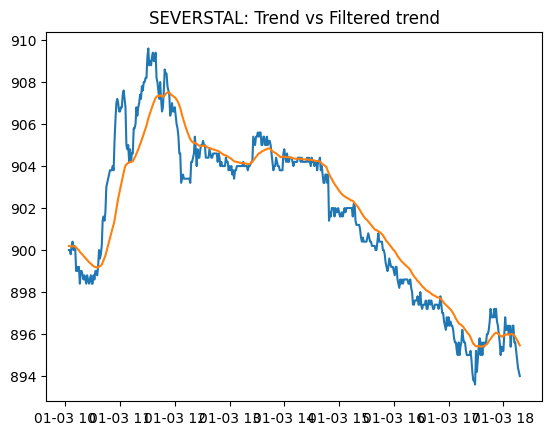

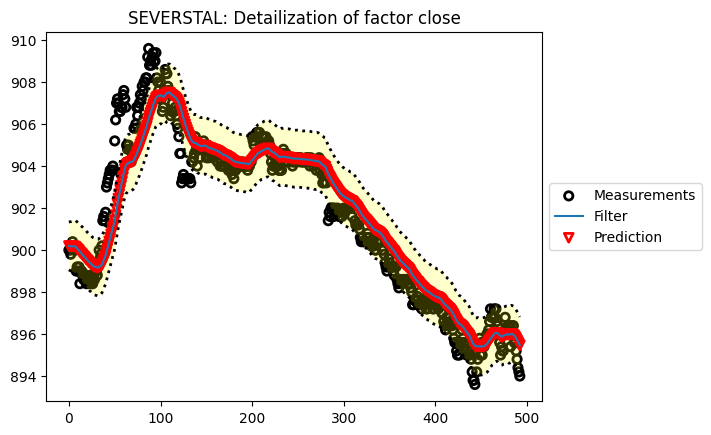

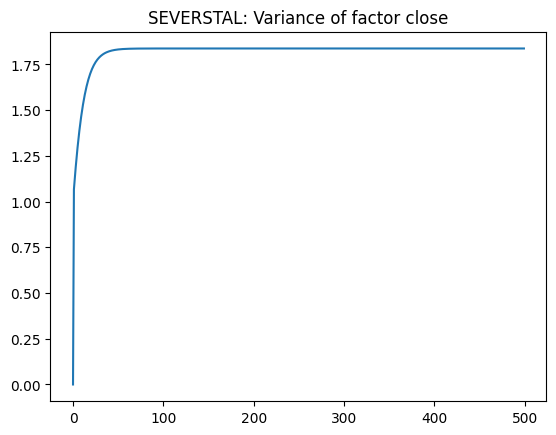

In [10]:
# COMPANY = "SBERBANK"
for COMPANY in companies:
    COL_GROUP = "begin"
    COL_DATA = "close"
    COL_DATA_FULL = f"{COMPANY}_{COL_DATA}"

    df_proc = df[COMPANY][[COL_GROUP, COL_DATA_FULL]].dropna()

    daily_groups = df_proc.groupby(pd.Grouper(key=COL_GROUP, freq="D"))

    filtered_data = []
    filtered_data_vars = []

    def F_func(x, t):
        return np.array([x[0]])

    def H_func(x, t):
        return np.array([x[0]])

    state_dim = 1

    for _, group in daily_groups:
        if not group.empty:
            filter_hist_states = np.empty(shape=group.shape[0])
            filter_vars_states = np.empty(shape=group.shape[0])

            F, H, Q, R, P0, x0 = generate_kalman_matrices_from_timeseries(
                time_series_data=group.filter(like=COL_DATA), state_dimension=state_dim, process_noise_scale=0.1, measurement_noise_scale=0.1, initial_estimation_error_scale=1.0
            )

            R = R + 20

            ekf = ExtendedKalmanFilter(F_func=F_func, H_func=H_func, Q=Q, R=R, x0=x0.flatten(), P0=P0)

            for t in range(1, group.shape[0]):
                observation = group.filter(like=COL_DATA).iloc[t]

                ekf.predict(1)
                ekf.update(observation, t)

                filter_hist_states[t] = ekf.get_state()[0]
                filter_vars_states[t] = ekf.P
                
            filtered_data.append(filter_hist_states)
            filtered_data_vars.append(filter_vars_states)

        break


    filtered_data = np.hstack(filtered_data)        
    filtered_data_vars = np.hstack(filtered_data_vars)

    processed_df = pd.concat([df_proc.begin, 
                            df_proc[COL_DATA_FULL],
                            pd.DataFrame(filtered_data, columns=["pred"]),
                            pd.DataFrame(filtered_data_vars, columns=["var_pred"])], axis=1).dropna()[5:]

    plt.plot(processed_df.begin, processed_df[COL_DATA_FULL])
    plt.plot(processed_df.begin, processed_df["pred"])
    plt.title(f'{COMPANY}: Trend vs Filtered trend')

    plt.show()

    plots.plot_measurements(processed_df[COL_DATA_FULL])
    plots.plot_filter(processed_df["pred"], var=processed_df["var_pred"])
    plots.plot_predictions(processed_df["pred"])
    plots.show_legend()
    plt.title(f"{COMPANY}: Detailization of factor {COL_DATA}")

    plt.show()

    plt.plot(filtered_data_vars)
    plt.title(f'{COMPANY}: Variance of factor {COL_DATA}')

    plt.show()

[[0.8]] [[1.]] [[0.1]] [[0.40386372]] [[1.]] [[141.75]]


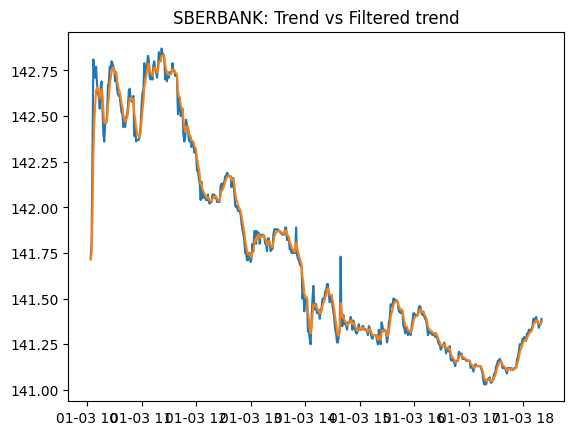

[[0.8]] [[1.]] [[0.1]] [[0.20103321]] [[1.]] [[162.716]]


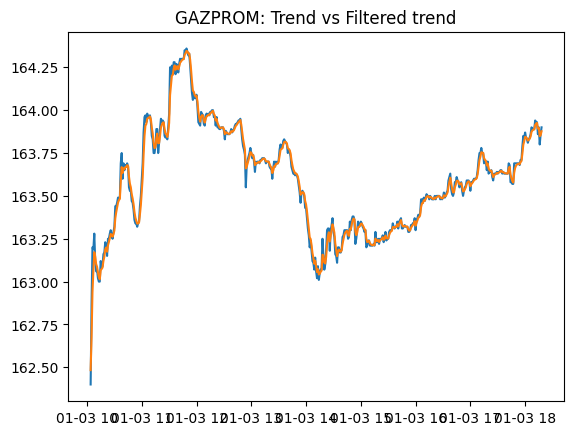

[[0.8]] [[1.]] [[0.1]] [[15.58119296]] [[1.]] [[900.24]]


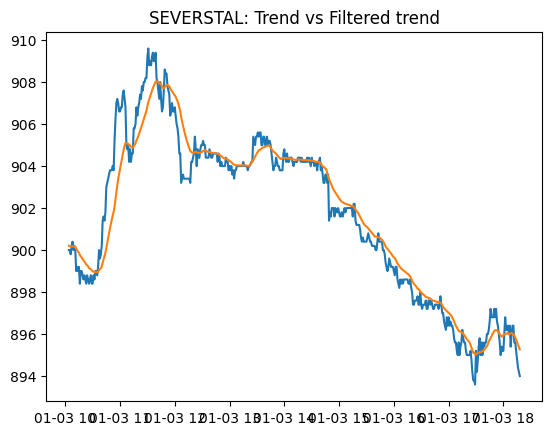

In [9]:
# COMPANY = "SBERBANK"
for COMPANY in companies:
    COL_GROUP = "begin"
    COL_DATA = "close"
    COL_DATA_FULL = f"{COMPANY}_{COL_DATA}"

    df_proc = df[COMPANY][[COL_GROUP, COL_DATA_FULL]].dropna()

    daily_groups = df_proc.groupby(pd.Grouper(key=COL_GROUP, freq="D"))

    filtered_data = []

    def F_func(x, t):
        return np.array([x[0]])

    def H_func(x, t):
        return np.array([x[0]])

    state_dim = 1

    for _, group in daily_groups:
        if not group.empty:
            filter_hist_states = np.empty(shape=group.shape[0])

            F, H, Q, R, P0, x0 = generate_kalman_matrices_from_timeseries(
                time_series_data=group.filter(like=COL_DATA), state_dimension=state_dim, process_noise_scale=0.1, measurement_noise_scale=0.1, initial_estimation_error_scale=1.0
            )

            print(F, H, Q, R, P0, x0)

            ekf = ExtendedKalmanFilter(F_func=F_func, H_func=H_func, Q=Q, R=R, x0=x0.flatten(), P0=P0)

            for t in range(0, group.shape[0]):
                observation = group.filter(like=COL_DATA).iloc[t]

                ekf.predict(t)
                ekf.update(observation, t)

                filter_hist_states[t] = ekf.get_state()[0]

                
            filtered_data.append(filter_hist_states)
            # filtered_data_var.append(filter_vars_states)
            
            break

    filtered_data = np.hstack(filtered_data)        
    # filtered_data_vars = np.hstack(filtered_data_vars)

    processed_df = pd.concat([df_proc.begin, 
                            df_proc[COL_DATA_FULL],
                            pd.DataFrame(filtered_data, columns=["pred"])], axis=1).dropna()[5:]

    plt.plot(processed_df.begin, processed_df[COL_DATA_FULL])
    plt.plot(processed_df.begin, processed_df["pred"])
    plt.title(f'{COMPANY}: Trend vs Filtered trend')

    plt.show()


In [20]:
df_proc = df["SBERBANK"][["begin", "SBERBANK_close", "SBERBANK_volume"]].dropna()

# daily_groups = df_proc.groupby(pd.Grouper(key='begin', freq='D'))

F, H, Q, R, P_0, X_0 = generate_kalman_matrices_from_timeseries(
    time_series_data=df_proc.values[:, [1,2]].astype("float64"),
    state_dimension=2,
    process_noise_scale=0.1,
    measurement_noise_scale=0.1,
    initial_estimation_error_scale=1.0
)

# Создание и выполнение фильтра
kf = KalmanFilterWithAuxiliaryFactors(F, H, Q, R, X_0, P_0)
X_est, P_est = kf.run(df_proc.values[:,1].reshape(-1,1).astype("float64"),
                      df_proc.values[:,2].reshape(-1,1).astype("float64"))


filter_hist_states

for t in range(T):
    kf.predict()  # Шаг предсказания
    kf.update(df_proc.values[:,1].reshape(-1,1).astype("float64"),
              df_proc.values[:,2].reshape(-1,1).astype("float64"))  # Шаг обновления
    
    filter_hist_states[t] = kf.get_state()  # Сохранение оценки состояния


In [118]:
pd.DataFrame(np.hstack([df_proc[["SBERBANK_close", "SBERBANK_volume"]].values, X_est]), 
             columns=["SBERBANK_close", "SBERBANK_volume", "SBERBANK_close_pred", "SBERBANK_volume_pred"])

NameError: name 'X_est' is not defined

In [ ]:
processed_df = pd.concat([df_proc.begin, 
                        df_proc.SBERBANK_close,
                        df_proc.SBERBANK_volume,
                        pd.DataFrame(filtered_data, columns=["pred_close", "pred_volume"]),
                        pd.DataFrame(filtered_data_var, columns=["var_pred_close", "var_pred_volume"])], axis=1).dropna()[5:]

plots.plot_measurements(processed_df["SBERBANK_close"])
plots.plot_filter(processed_df["pred"], var=processed_df["var_pred"])
plots.plot_predictions(processed_df["pred"])
plots.show_legend()
plt.title("Detailization")

plt.show()

plt.plot(filtered_data_vars)
plt.title('Variance')

plt.show()